In [2]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split



In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [3]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'C:/Users/Frank Shi/Desktop/train_data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('C:/Users/Frank Shi/Desktop/train_data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('C:/Users/Frank Shi/Desktop/train_data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


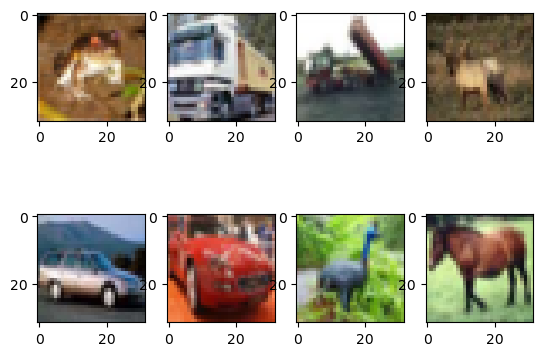

In [4]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


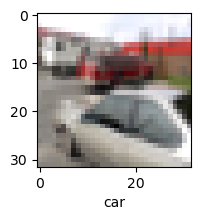

In [5]:
def show_imgs(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index]/225)
    plt.xlabel(classes[y[index]])

show_imgs(imgs, noisy_labels, 49999)

## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [6]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [23]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [8]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.1. Model I

In [67]:
X_train_model1, X_test_model1, y_train_model1, y_test_model1 = train_test_split(imgs, noisy_labels, test_size=0.3)


## normalization
X_train_model1 = X_train_model1 / 225
X_test_model1 = X_test_model1/225
print(X_train_model1.shape)
print(X_test_model1.shape)


IMG_SIZE = 32
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

## model construction
model1 = tf.keras.Sequential([
    ### CNN layers
        tf.keras.layers.Conv2D(32,(3,3),activation ='relu', input_shape=(32,32,3)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.2),
    
        tf.keras.layers.Conv2D(32,(3,3),activation ='relu', input_shape=(32,32,3)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Conv2D(64,(3,3), activation ='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.2),
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200, activation = 'relu'),
        tf.keras.layers.Dense(100, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation = 'softmax')        
                                ])
    ###################### 21%


model1.compile(optimizer= tf.keras.optimizers.Adam(0.0001),
              ### YOUR CODE HERE ###
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              ######################
              metrics=['sparse_categorical_accuracy'])

### early stop 
callback = tf.keras.callbacks.EarlyStopping( patience=4)

start = time.time()
## fit model
history_1 = model1.fit(X_train_model1, y_train_model1, batch_size = 32, epochs=15, validation_split = 0.2, callbacks = [callback])
end = time.time()


model1.evaluate(X_test_model1, y_test_model1)

(35000, 32, 32, 3)
(15000, 32, 32, 3)
Epoch 1/15


C:\Users\Frank Shi\anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


875/875 [==============================] - 15s 16ms/step - loss: 2.3025 - sparse_categorical_accuracy: 0.1080 - val_loss: 2.2969 - val_sparse_categorical_accuracy: 0.1227
Epoch 2/15
875/875 [==============================] - 16s 18ms/step - loss: 2.2907 - sparse_categorical_accuracy: 0.1262 - val_loss: 2.2896 - val_sparse_categorical_accuracy: 0.1331
Epoch 3/15
875/875 [==============================] - 17s 19ms/step - loss: 2.2859 - sparse_categorical_accuracy: 0.1306 - val_loss: 2.2847 - val_sparse_categorical_accuracy: 0.1386
Epoch 4/15
875/875 [==============================] - 17s 19ms/step - loss: 2.2800 - sparse_categorical_accuracy: 0.1371 - val_loss: 2.2779 - val_sparse_categorical_accuracy: 0.1543
Epoch 5/15
875/875 [==============================] - 17s 20ms/step - loss: 2.2733 - sparse_categorical_accuracy: 0.1492 - val_loss: 2.2707 - val_sparse_categorical_accuracy: 0.1604
Epoch 6/15
875/875 [==============================] - 16s 18ms/step - loss: 2.2663 - sparse_categoric

[2.233116388320923, 0.19913333654403687]

In [23]:
# summarize history for accuracy

print("training time for model 1: " + str((end - start)/60) + 'mins')


training time for model 1: 4.414872618516286mins


In [36]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...
    image = image/225
    predictions = model1.predict(image)
    return np.argmax(predictions)

In [68]:
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here.
    return np.argmax(model1.predict(image/225), axis = -1)


### 2.2. Model II


In [10]:
## Base model of model2

#transfer learning model without Image augmentation

#### Image prepreration and nomalization
from sklearn.model_selection import train_test_split
clean_imgs = imgs[0:10000]
noisy_imgs = imgs[10000:]
noisy_labels_400000 =  noisy_labels[10000:]

### split the clean dataset into train and test
X_train_clean, X_test, y_train_clean, y_test = train_test_split(clean_imgs, clean_labels, test_size=0.3)

## combine the clean train dataset with noisy dataset
X_train_combined = np.concatenate((X_train_clean, noisy_imgs))
y_train_combined = np.concatenate((y_train_clean, noisy_labels_400000))


## normalization
X_test = X_test / 225
X_train_combined = X_train_combined / 225
X_train_clean = X_train_clean/225


IMG_SIZE = 32
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

### loade pretrained model Mobilnet
MobileNet = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
MobileNet.trainable= True

### construct NN 
model = tf.keras.Sequential([
    MobileNet, 
    #tf.keras.layers.Conv2D(12,(3,3), activation = 'relu', input_shape = (7, 7, 1280)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(500, activation = 'relu'),
    tf.keras.layers.Dense(200, activation = 'relu'),
    
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation = 'softmax')
                  ])

model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              ### YOUR CODE HERE ###
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              ######################
              metrics=['sparse_categorical_accuracy'])

callback = tf.keras.callbacks.EarlyStopping( patience=4)

start = time.time()
history_2_1 =model.fit(X_train_clean, y_train_clean, batch_size = 32, epochs=60, validation_split = 0.2, callbacks = [callback])
end = time.time()
model.evaluate(X_test, y_test)

Epoch 1/60


C:\Users\Frank Shi\anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


175/175 [==============================] - 25s 114ms/step - loss: 2.4953 - sparse_categorical_accuracy: 0.1443 - val_loss: 2.3203 - val_sparse_categorical_accuracy: 0.0936
Epoch 2/60
175/175 [==============================] - 23s 129ms/step - loss: 2.1047 - sparse_categorical_accuracy: 0.2463 - val_loss: 2.3652 - val_sparse_categorical_accuracy: 0.1150
Epoch 3/60
175/175 [==============================] - 20s 116ms/step - loss: 1.8791 - sparse_categorical_accuracy: 0.3248 - val_loss: 2.2675 - val_sparse_categorical_accuracy: 0.1507
Epoch 4/60
175/175 [==============================] - 20s 115ms/step - loss: 1.7286 - sparse_categorical_accuracy: 0.3905 - val_loss: 2.2394 - val_sparse_categorical_accuracy: 0.1529
Epoch 5/60
175/175 [==============================] - 20s 116ms/step - loss: 1.6215 - sparse_categorical_accuracy: 0.4271 - val_loss: 2.2526 - val_sparse_categorical_accuracy: 0.1664
Epoch 6/60
175/175 [==============================] - 21s 117ms/step - loss: 1.5104 - sparse_cat

[1.2485606670379639, 0.6526666879653931]

In [11]:
# summarize history for accuracy

print("training time for model 1: " + str((end - start)/60) + 'mins')

training time for model 1: 11.619206710656483mins


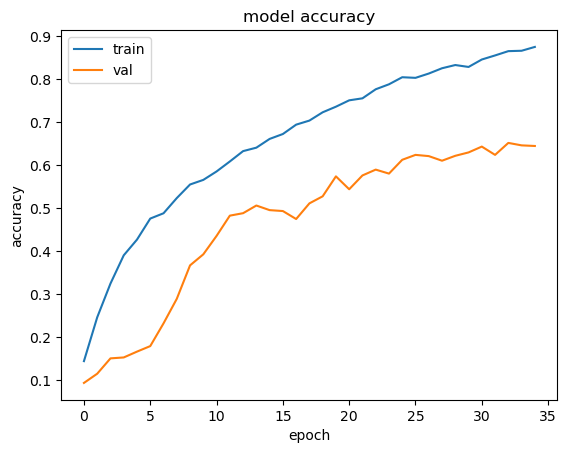

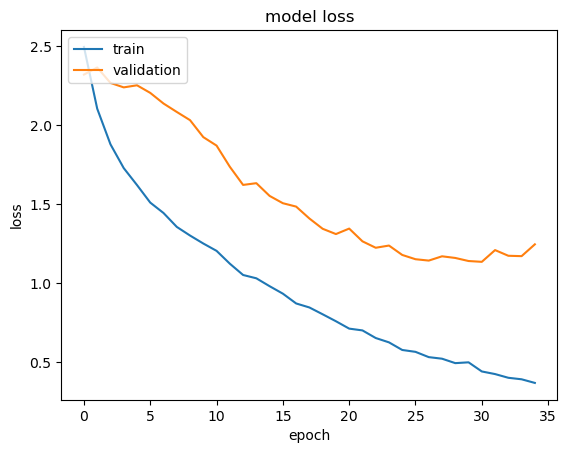

In [19]:
# model run time
print("training time for model 1: " + str((end - start)/60) + 'mins')

#### plot the acc and loss
plt.plot(history_2_1.history['sparse_categorical_accuracy'])
plt.plot(history_2_1.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##plot loss
plt.plot(history_2_1.history['loss'])
plt.plot(history_2_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [80]:

### Save the  model
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
model_final.save('Model_clean.h5')
print('Model Saved!')
savedModel=load_model('Model_clean.h5')


Model Saved!
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_16  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_35 (Dropout)        (None, 1280)              0         
                                                                 
 dense_54 (Dense)            (None, 500)               640500    
                                                                 
 dropout_36 (Dropout)        (None, 500)               0         
                                                                 
 dense_55 (Dense)            (None, 200)

94/94 [==============================] - 3s 31ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


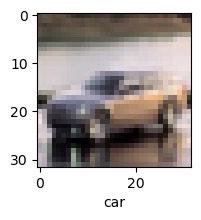

In [62]:
### show ith image prediction
i = 600
print(classes[np.argmax(model.predict(X_test)[i])])

### show ith image in X_test
show_imgs(X_test*225, y_test, i)

## Label Corrrection

In [17]:

### label Correction
##Create a empty list capture prob>0.85
confident_imgs = []
model_predict = model.predict(noisy_imgs/225)
for i in range(len(noisy_imgs)):
    if sum(model_predict[i]>0.85) == 1:
        confident_imgs.append(i)

##length of selected noisy labels
print(len(confident_imgs))


### add train_clean date and corrected  noisy labels
X_train_final = np.concatenate((X_train_clean, noisy_imgs[confident_imgs]/225)) ####diveide by 225
y_train_final = np.concatenate((y_train_clean, np.argmax(model.predict(noisy_imgs/225),axis=-1)[confident_imgs]))

print(len(X_train_final))
print(len(y_train_final))
print(len(confident_imgs))



1250/1250 [==============================] - 23s 18ms/step
21744
1250/1250 [==============================] - 23s 18ms/step
28744
28744
21744


In [53]:
###show how many corrected labels are captured by classes
n = np.argmax(model.predict(noisy_imgs/225),axis=-1)[confident_imgs]
Counter(n)

1250/1250 [==============================] - 36s 28ms/step


Counter({6: 2395,
         8: 1233,
         4: 1073,
         0: 3132,
         3: 1268,
         2: 2216,
         9: 2492,
         1: 2545,
         7: 1673,
         5: 853})

## Re-train a new model with corrected labels

In [20]:
## retrain the model with corrected labels
MobileNet.trainable= True
model_final = tf.keras.Sequential([
    MobileNet, 
    #tf.keras.layers.Conv2D(12,(3,3), activation = 'relu', input_shape = (7, 7, 1280)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(500, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation = 'softmax')
                  ])

model_final.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              ### YOUR CODE HERE ###
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              ######################
              metrics=['sparse_categorical_accuracy'])

callback = tf.keras.callbacks.EarlyStopping(patience=4)
start = time.time()
history_final = model_final.fit(X_train_final, y_train_final, batch_size = 32, epochs=15, validation_split = 0.2, callbacks = [callback])
end = time.time()
model_final.evaluate(X_test, y_test)

Epoch 1/15
719/719 [==============================] - 69s 90ms/step - loss: 0.8212 - sparse_categorical_accuracy: 0.7529 - val_loss: 0.2147 - val_sparse_categorical_accuracy: 0.9355
Epoch 2/15
719/719 [==============================] - 72s 101ms/step - loss: 0.6096 - sparse_categorical_accuracy: 0.8187 - val_loss: 0.2475 - val_sparse_categorical_accuracy: 0.9235
Epoch 3/15
719/719 [==============================] - 81s 113ms/step - loss: 0.5417 - sparse_categorical_accuracy: 0.8379 - val_loss: 0.3119 - val_sparse_categorical_accuracy: 0.8970
Epoch 4/15
719/719 [==============================] - 83s 115ms/step - loss: 0.5072 - sparse_categorical_accuracy: 0.8459 - val_loss: 0.2804 - val_sparse_categorical_accuracy: 0.9087
Epoch 5/15
94/94 [==============================] - 3s 24ms/step - loss: 1.0752 - sparse_categorical_accuracy: 0.6863


[1.0752449035644531, 0.6863333582878113]

training time for model 2: 6.497231590747833mins


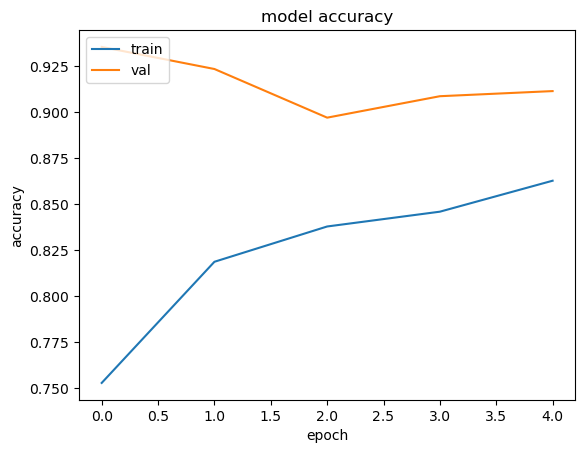

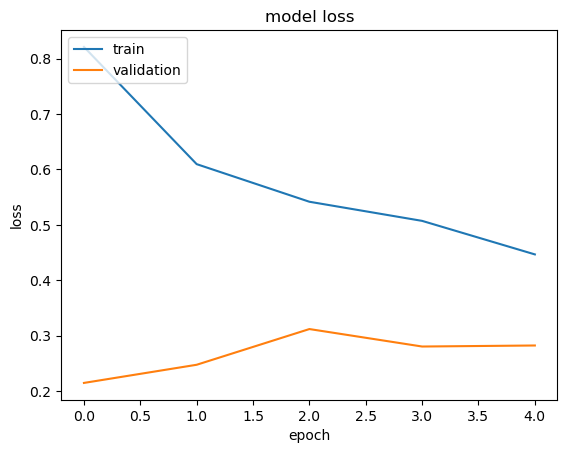

In [22]:
# model run time
print("training time for model 2: " + str((end - start)/60) + 'mins')

#### plot the acc and loss
plt.plot(history_final.history['sparse_categorical_accuracy'])
plt.plot(history_final.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##plot loss
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [79]:

### Save the final model
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
model_final.save('Model_final.h5')
print('Model Saved!')
savedModel=load_model('Model_final.h5')
savedModel.summary()
 


Model Saved!
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_16  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_35 (Dropout)        (None, 1280)              0         
                                                                 
 dense_54 (Dense)            (None, 500)               640500    
                                                                 
 dropout_36 (Dropout)        (None, 500)               0         
                                                                 
 dense_55 (Dense)            (None, 200)

In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
model_final=load_model('Model_final.h5')

In [77]:
pip install pyyaml h5py

Note: you may need to restart the kernel to use updated packages.


In [46]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL II]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...
                                               
    image = np.expand_dims(image, axis=0)
    return np.argmax(model_final.predict(image/225))    #Take one single img dataset as input

In [51]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL II]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...
    return np.argmax(model_final.predict(image/225), axis = -1) # take  imgs  dataset as input

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [42]:
y_true = test_labels.reshape(-1)
y_pred = model_II(test_images)
print(len(y_true))
print(len(y_pred))

313/313 [==============================] - 6s 19ms/step
10000
10000


In [70]:
def evaluation(model, test_labels, test_imgs):  ## take images dataset as input
    y_true = test_labels.reshape(-1)
    y_pred = model(test_imgs)
    print(classification_report(y_true, y_pred))
    
evaluation(model_II, test_labels, test_images)

313/313 [==============================] - 6s 18ms/step
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1000
           1       0.79      0.88      0.83      1000
           2       0.69      0.50      0.58      1000
           3       0.47      0.56      0.51      1000
           4       0.67      0.63      0.65      1000
           5       0.63      0.58      0.60      1000
           6       0.69      0.83      0.75      1000
           7       0.73      0.72      0.72      1000
           8       0.87      0.71      0.78      1000
           9       0.77      0.85      0.81      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



In [54]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [55]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'C:/Users/Frank Shi/Desktop/train_data/images/{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

OSError: ../data/test_labels.csv not found.

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

## Save output to CSV file

In [60]:
#predicted models from baseline model
baseline_pred = []
for i in test_images: 
    baseline_pred.append(baseline_model(i)[0])      
print(len(baseline_pred))


10000


In [72]:
### predicted labels from model1 and model2
model1_pred = model_I(test_images)
print(len(modelI_pred))

model2_pred = model_II(test_images)
print(len(modelII_pred))


313/313 [==============================] - 1s 4ms/step
10000
313/313 [==============================] - 6s 19ms/step
10000


In [74]:
#Save csv file 
import pandas as pd 

results = {
    "Baseline": baseline_pred,
    "Model I": model1_pred,
    "Model II": model2_pred
}

results_df = pd.DataFrame(results)
results_df.to_csv("C:/Users/Frank Shi/Desktop/train_data/output/label_prediction.csv")